# Analisis completo de imagen de calcio

Este notebook reproduce el flujo completo de la app: carga de datos, preprocesamiento, deteccion de eventos, calculo de metricas y analisis espectral. Cada seccion explica la teoria y el razonamiento detras de cada paso.

## Indice

1. Configuracion e imports
2. Carga de datos
3. Preprocesamiento: suavizado SG y filtrado Butterworth
4. Deteccion robusta de eventos (rolling MAD)
5. Metricas por estimulo
6. Analisis espectral (FFT y Welch)
7. Guia de seleccion de parametros

## 1. Configuracion e imports

Se importan librerias de analisis numerico, senales y graficos. Se utilizan de SciPy para filtros digitales (butter, filtfilt) y para espectros (welch).

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.integrate import trapezoid

# Configurar matplotlib para mejor visualizacion
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['lines.linewidth'] = 1.5

### Parametros base

- `sg_window`, `sg_poly`: Suavizado con Savitzky-Golay. Se ajustan polinomios locales conservando la forma de picos mejor que una media movil.
- `butter_type`, `butter_order`, `butter_cutoff`: Filtro Butterworth. Su respuesta suave evita oscilaciones de borde y mantiene transitorios si el corte se elige correctamente.
- `signal_window`, `k_up`, `k_down`: Parametros de deteccion robusta con baseline movil. El MAD es robusto a outliers.

Estos valores son iniciales; se ajustan segun el muestreo y duracion total del archivo.

In [2]:
# Savitzky-Golay
sg_window = 15      # muestras (se ajusta al fs)
sg_poly = 3         # orden polinomio

# Butterworth
butter_type = 'lowpass'  # lowpass, highpass, bandpass, bandstop
butter_order = 4         # mayor orden -> transicion mas abrupta
butter_cutoff = 0.05     # Hz

# Deteccion de eventos
signal_window = 20       # muestras para rolling MAD
k_up = 1.65              # umbral para subidas
k_down = 1.65            # umbral para bajadas

## 2. Carga de datos

Se asume la misma estructura que la app: carpeta `Experimentos/` con subcarpetas (ej: ID002_A_002/). Cada subcarpeta incluye:
- Un archivo `.txt` con matriz de senales (Time, ROI_1, ROI_2, ...)
- Un archivo `.csv` con vector de estimulos (duracion, nombre)

In [3]:
# Ubicar carpeta base
base_dir = os.path.join('..', 'Experimentos')
carpetas = sorted([c for c in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, c))])
print(f'Carpetas encontradas: {carpetas}')

# Seleccionar la primera carpeta (cambiar indice segun sea necesario)
exper = 0
archivos = os.listdir(os.path.join(base_dir, carpetas[exper]))
txt_files = [a for a in archivos if a.endswith('.txt')]
csv_files = [a for a in archivos if a.endswith('.csv')]

print(f'Usando carpeta: {carpetas[exper]}')
print(f'Archivos txt: {txt_files}, csv: {csv_files}')

# Cargar datos de senales
txt_path = os.path.join(base_dir, carpetas[exper], txt_files[0])
data = pd.read_csv(txt_path, sep='\t', skiprows=3, header=1)
data.columns = ['Time'] + [f'ROI_{i}' for i in range(1, len(data.columns))]
data.iloc[:, 0] = data.iloc[:, 0] / (1000 * 60)  # Convertir ms a minutos

# Cargar datos de estimulos
csv_path = os.path.join(base_dir, carpetas[exper], csv_files[0])
data_csv = pd.read_csv(csv_path, sep=';', decimal=',')
if len(data_csv.columns) > 0:
    data_csv.iloc[:, 0] = data_csv.iloc[:, 0].str.upper()

print(f'\nDatos de senales: {data.shape}')
print(f'Datos de estimulos: {data_csv.shape}')
print(f'Duracion total: {data["Time"].max():.1f} min')
data.head()

Carpetas encontradas: ['ID002_A_002']
Usando carpeta: ID002_A_002
Archivos txt: ['ID002_A_002.txt'], csv: ['estimulos.csv']

Datos de senales: (319, 11)
Datos de estimulos: (2, 3)
Duracion total: 27.0 min


,Time,ROI_1,ROI_2,ROI_3,ROI_4,ROI_5,ROI_6,ROI_7,ROI_8,ROI_9,ROI_10
0,0.000000,0.2439,0.1969,0.2452,0.1923,0.1283,0.2342,0.1851,0.1136,0.1492,0.2235
1,0.084925,0.2486,0.1922,0.2390,0.1964,0.1328,0.2389,0.1826,0.1229,0.1641,0.2203
2,0.169850,0.2461,0.1921,0.2401,0.1953,0.1308,0.2368,0.1817,0.1173,0.1641,0.2187
3,0.254775,0.2469,0.1954,0.2461,0.1969,0.1302,0.2358,0.1839,0.1176,0.1618,0.2188
4,0.339700,0.2407,0.1935,0.2460,0.1912,0.1266,0.2337,0.1855,0.1134,0.1539,0.2169


## 3. Preprocesamiento

### 3.1 Suavizado Savitzky-Golay

**Por que suavizar:** la senal tiene ruido instrumental (fluctuaciones rapidas despues del muestreo). 
Un filtro SG ajusta polinomios locales y conserva picos mejor que una media movil simple.

### 3.2 Filtro Butterworth

**Que es:** filtro digital IIR (respuesta infinita) con respuesta suave. En modo paso bajo (lowpass) elimina oscilaciones rapidas.

**Ventaja sobre FFT:** el FFT es global y puede distorsionar bordes. Butterworth es causal (si invertimos con filtfilt, es cero-fase) y se adapta bien a transitorios.

**Eleccion de corte:** debe estar por encima de la frecuencia de interes biologico (tipicamente <0.1 Hz para calcio) y eliminar ruido de alta frecuencia (>0.5 Hz).

In [4]:
def estimate_sampling_rate(time_min):
    """Estima la frecuencia de muestreo en Hz a partir de array de tiempos en minutos."""
    if len(time_min) < 2:
        return 0.0
    dt_min = np.nanmedian(np.diff(time_min))
    if dt_min <= 0:
        return 0.0
    return 1.0 / (dt_min * 60.0)

def savgol_smooth(x, window, polyorder):
    """Aplica filtro Savitzky-Golay. Asegura ventana impar."""
    if window % 2 == 0:
        window += 1
    return signal.savgol_filter(x, window_length=window, polyorder=polyorder)

def butter_filter(x, sampling_rate_hz, ftype, cutoff_hz, order=4):
    """Aplica filtro Butterworth. Retorna copia sin filtrar si parametros invalidos."""
    if sampling_rate_hz <= 0:
        return x.copy()
    
    nyquist = 0.5 * sampling_rate_hz
    
    # Validar cutoff(s)
    if isinstance(cutoff_hz, (tuple, list)):
        low, high = cutoff_hz
        if low <= 0 or high >= nyquist or low >= high:
            return x.copy()
        wn = [low / nyquist, high / nyquist]
    else:
        if cutoff_hz <= 0 or cutoff_hz >= nyquist:
            return x.copy()
        wn = cutoff_hz / nyquist
    
    b, a = signal.butter(order, wn, btype=ftype, analog=False)
    return signal.filtfilt(b, a, x)

# Estimar fs
t = data['Time'].to_numpy()
fs = estimate_sampling_rate(t)
print(f'Frecuencia de muestreo estimada: {fs:.2f} Hz')

# Aplicar filtros
data_sg = data.copy()
data_bw = data.copy()

for col in data.columns[1:]:
    x = data[col].to_numpy()
    data_sg[col] = savgol_smooth(x, sg_window, sg_poly)
    data_bw[col] = butter_filter(x, fs, butter_type, butter_cutoff, order=butter_order)

print('Filtros aplicados.')
data_sg.head()

Frecuencia de muestreo estimada: 0.20 Hz
Filtros aplicados.


,Time,ROI_1,ROI_2,ROI_3,ROI_4,ROI_5,ROI_6,ROI_7,ROI_8,ROI_9,ROI_10
0,0.000000,0.246011,0.196021,0.241274,0.194463,0.130353,0.235663,0.183623,0.117437,0.154696,0.222322
1,0.084925,0.246224,0.193634,0.243228,0.194593,0.130259,0.236383,0.183751,0.117262,0.157798,0.220822
2,0.169850,0.245797,0.192631,0.244144,0.194570,0.129942,0.236570,0.183748,0.117035,0.159802,0.219734
3,0.254775,0.244850,0.192746,0.244160,0.194419,0.129445,0.236307,0.183625,0.116764,0.160872,0.218981
4,0.339700,0.243501,0.193716,0.243415,0.194163,0.128811,0.235674,0.183392,0.116456,0.161176,0.218487


### Comparacion: Original vs SG vs Butterworth

Se visualizan los tres filtrados para la primera ROI. Nota: Butterworth puede ser diferente a SG.

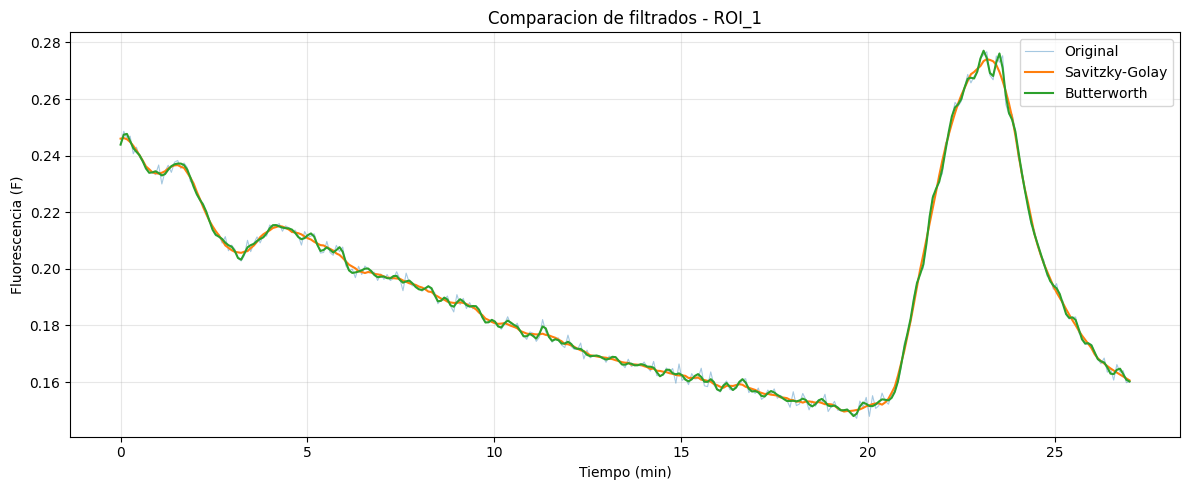

SG: ventana=15, orden=3
Butterworth: tipo=lowpass, corte=0.05 Hz, orden=4


In [5]:
roi = data.columns[1]  # Primera ROI

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(t, data[roi], label='Original', alpha=0.4, linewidth=0.8)
ax.plot(t, data_sg[roi], label='Savitzky-Golay', linewidth=1.5)
ax.plot(t, data_bw[roi], label='Butterworth', linewidth=1.5)
ax.legend(loc='upper right')
ax.set_xlabel('Tiempo (min)')
ax.set_ylabel('Fluorescencia (F)')
ax.set_title(f'Comparacion de filtrados - {roi}')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f'SG: ventana={sg_window}, orden={sg_poly}')
print(f'Butterworth: tipo={butter_type}, corte={butter_cutoff} Hz, orden={butter_order}')

## 4. Deteccion robusta de eventos (rolling MAD)

### Por que MAD (Median Absolute Deviation)?

El MAD es mucho mas robusto a valores atipicos que la desviacion estandar. En senales con picos amplios, usar desv. estandar infla el umbral de deteccion y pierde eventos verdaderos.

**Definicion:** MAD = mediana(|x - mediana(x)|). La sigma robusta = MAD / 0.6745 (conversion a desv. estandar para distribucion gaussiana).

### Rolling MAD

Se calcula MAD en ventana movil (`signal_window`) para adaptar el baseline y sensibilidad a cambios graduales.

### Deteccion con histéresis

Se usan dos umbrales: `k_up` (subida) y `k_down` (bajada) para evitar oscilaciones cerca del threshold.

In [6]:
def rolling_mad_sigma(x, w):
    """Calcula rolling MAD normalizado (sigma robusta) de una senal."""
    s = pd.Series(x)
    med = s.rolling(w, center=True, min_periods=max(5, w // 3)).median()
    mad = (s - med).abs().rolling(w, center=True, min_periods=max(5, w // 3)).median()
    sigma = (mad / 0.6745).to_numpy(copy=True)
    sigma[np.isnan(sigma)] = np.nanmedian(sigma)
    sigma[sigma < 1e-12] = np.nanmedian(sigma[sigma >= 1e-12]) if np.any(sigma >= 1e-12) else 1e-6
    return sigma

def robust_event_detection(x, w=20, k_up=1.65, k_down=1.65, influence=0.95, run_min=10):
    """Deteccion robusta usando rolling MAD e histéresis.
    
    Retorna:
        mask: array de valores {-1, 0, 1} para bajada, reposo, subida
        baseline_arr: baseline en cada punto
        std_arr: sigma robusta en cada punto
    """
    n = len(x)
    mask = np.zeros(n)
    
    # Inicializar con primeros w puntos
    x_filt = list(x[:w])
    baseline = np.nanmedian(x_filt)
    mad = np.nanmedian(np.abs(np.array(x_filt) - baseline))
    std_dev = mad / 0.6745 if mad > 0 else 1e-6
    
    baseline_arr = np.zeros(n)
    std_arr = np.zeros(n)
    baseline_arr[:w] = baseline
    std_arr[:w] = std_dev
    
    for i in range(w, n):
        diff = x[i] - baseline
        
        # Histéresis: deteccion de subida o continuacion
        if (diff > k_up * std_dev and diff > 0) or (diff > 0 and mask[i - 1] == 1):
            mask[i] = 1
            x_filt.append(influence * x[i] + (1 - influence) * x_filt[-1])
        # Deteccion de bajada o continuacion
        elif (diff < -k_down * std_dev and diff < 0) or (diff < 0 and mask[i - 1] == -1):
            mask[i] = -1
            x_filt.append(influence * x[i] + (1 - influence) * x_filt[-1])
        else:
            mask[i] = 0
            x_filt.append(x[i])
        
        # Merge cortos eventos si hay continuidad
        if i > w + run_min:
            if mask[i] == 1 and np.sum(mask[i-run_min:i-1] == 1) > 0.8 * run_min:
                mask[i-run_min:i] = 1
            elif mask[i] == -1 and np.sum(mask[i-run_min:i-1] == -1) > 0.8 * run_min:
                mask[i-run_min:i] = -1
        
        # Mantener ventana y actualizar baseline
        x_filt = x_filt[-w:]
        baseline = np.nanmedian(x_filt)
        mad = np.nanmedian(np.abs(np.array(x_filt) - baseline))
        std_dev = mad / 0.6745 if mad > 0 else 1e-6
        
        baseline_arr[i] = baseline
        std_arr[i] = std_dev
    
    return mask, baseline_arr, std_arr

### Ejemplo de deteccion

Se aplica la deteccion robusta a la señal suavizada con SG. Se grafica la senal, el baseline movil, los umbrales y la mascara de eventos.

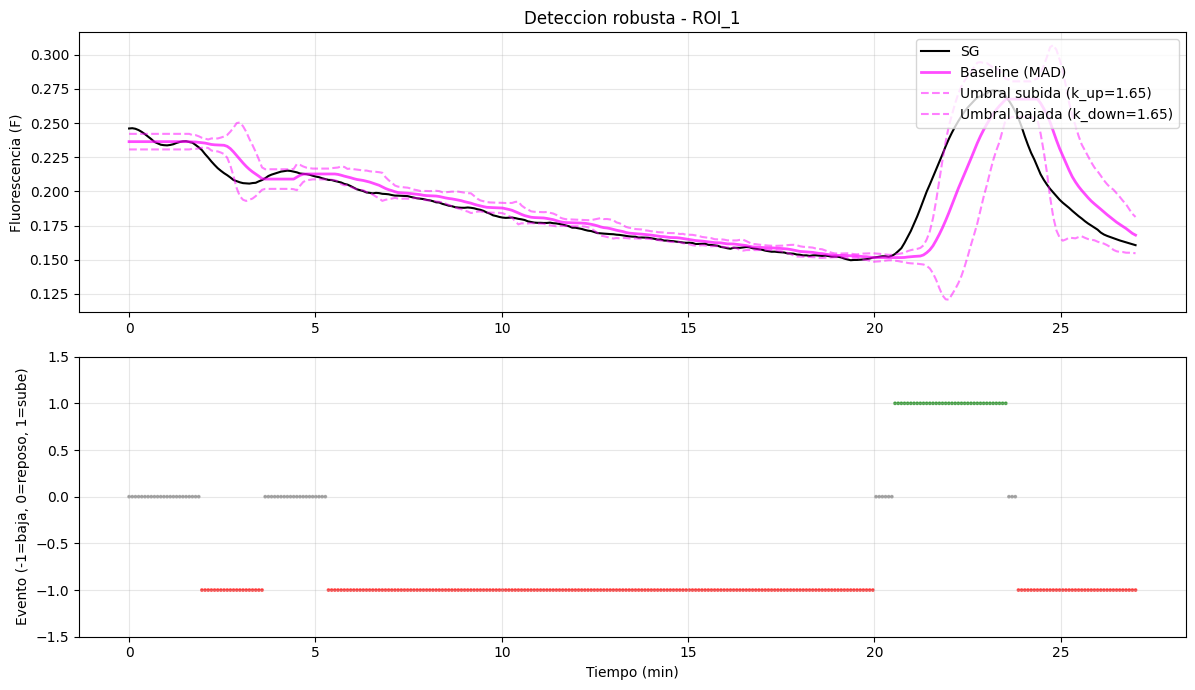

Detectados: 36 muestras con subidas, 231 con bajadas


In [7]:
# Aplicar deteccion a SG
x_sg = data_sg[roi].to_numpy()
mask, baseline, std = robust_event_detection(x_sg, w=signal_window, k_up=k_up, k_down=k_down)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 7))

# Senal y baseline
ax1.plot(t, x_sg, color='black', label='SG', linewidth=1.5)
ax1.plot(t, baseline, color='magenta', alpha=0.7, linewidth=2, label='Baseline (MAD)')
ax1.plot(t, baseline + k_up * std, color='magenta', linestyle='--', alpha=0.5, label=f'Umbral subida (k_up={k_up})')
ax1.plot(t, baseline - k_down * std, color='magenta', linestyle='--', alpha=0.5, label=f'Umbral bajada (k_down={k_down})')
ax1.legend(loc='upper right')
ax1.set_ylabel('Fluorescencia (F)')
ax1.set_title(f'Deteccion robusta - {roi}')
ax1.grid(True, alpha=0.3)

# Mascara de eventos
colors = np.where(mask == 1, 'green', np.where(mask == -1, 'red', 'gray'))
ax2.scatter(t, mask, c=colors, s=3, alpha=0.6)
ax2.set_xlabel('Tiempo (min)')
ax2.set_ylabel('Evento (-1=baja, 0=reposo, 1=sube)')
ax2.set_ylim(-1.5, 1.5)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

n_ups = np.sum(mask == 1)
n_downs = np.sum(mask == -1)
print(f'Detectados: {n_ups} muestras con subidas, {n_downs} con bajadas')

## 5. Metricas por estimulo

Se calcula para cada estimulo:
- **Duracion**: desde primer evento de subida hasta ultimo evento de bajada
- **Area bajo la curva**: integracion numerica (regla trapezoidal)
- **Maximo**: pico de fluorescencia durante el evento

Esto emula el comportamiento de la app.

In [8]:
def calculate_metrics(signal_data, time_array, event_mask, stim_start, stim_end, next_start=None):
    """Calcula metricas (area, duracion, maximo) durante un estimulo.
    
    Args:
        signal_data: senal (fluorescencia)
        time_array: tiempos en minutos
        event_mask: mascara de eventos {-1, 0, 1}
        stim_start: tiempo inicio estimulo (min)
        stim_end: tiempo fin estimulo (min)
        next_start: tiempo inicio del siguiente estimulo (opcional)
    
    Returns:
        dict con 'area', 'duration', 'max'  o None si no hay eventos
    """
    effective_end = next_start if next_start is not None else time_array[-1]
    
    # Buscar primer evento de subida tras inicio de estimulo
    start_indices = np.where((time_array >= stim_start) & (time_array <= effective_end) & (event_mask == 1))[0]
    if len(start_indices) == 0:
        return None
    
    first_up = start_indices[0]
    
    # Buscar ultimo evento de bajada entre primer subida y siguiente estimulo
    down_indices = np.where((time_array >= time_array[first_up]) & (time_array <= effective_end) & (event_mask == -1))[0]
    if len(down_indices) == 0:
        last_down = len(time_array) - 1
    else:
        last_down = down_indices[-1]
    
    # Calcular metricas en rango [first_up, last_down]
    event_signal = signal_data[first_up:last_down+1]
    event_time = time_array[first_up:last_down+1]
    
    if len(event_signal) == 0:
        return None
    
    duration = event_time[-1] - event_time[0]
    area = trapezoid(event_signal, event_time)
    maximum = np.max(event_signal)
    
    return {
        'area': area,
        'duration': duration,
        'max': maximum
    }

### Calculo de metricas para estimulos del archivo CSV

In [9]:
# Preparar dataframe de estimulos
# Suponiendo que el CSV tiene columnas: Estimulo, Tiempo (min), Duracion (s)
if data_csv.shape[0] > 0 and data_csv.shape[1] >= 2:
    try:
        # Rename columnas
        stim_col = data_csv.columns[0]
        time_col = data_csv.columns[1] if len(data_csv.columns) > 1 else None
        
        # Convertir tiempos a minutos si es necesario
        stim_times = pd.to_numeric(data_csv.iloc[:, 1], errors='coerce').values
        
        # Calcular duracion de cada estimulo (asumiendo que es equidistante en tiempo)
        if len(stim_times) > 1:
            stim_duration = np.median(np.diff(stim_times)) * 0.5  # Aproximado
        else:
            stim_duration = 1.0
        
        print(f'Se encontraron {len(stim_times)} estimulos')
        print(f'Duracion aproximada de cada estimulo: {stim_duration:.2f} min')
        
        # Calcular metricas para cada estimulo
        metrics_list = []
        for i, stim_start in enumerate(stim_times):
            stim_end = stim_start + stim_duration
            next_start = stim_times[i + 1] if i + 1 < len(stim_times) else None
            
            metrics = calculate_metrics(x_sg, t, mask, stim_start, stim_end, next_start)
            if metrics is not None:
                metrics['estimulo'] = i + 1
                metrics['tiempo_inicio'] = stim_start
                metrics_list.append(metrics)
        
        metrics_df = pd.DataFrame(metrics_list)
        print('\nMetricas calculadas:')
        print(metrics_df)
    except Exception as e:
        print(f'Error procesando CSV: {e}')
        print('Intentando con estructura alternativa...')
        metrics_df = pd.DataFrame()
else:
    print('No se pudo cargar CSV o esta vacio')
    metrics_df = pd.DataFrame()

Se encontraron 2 estimulos
Duracion aproximada de cada estimulo: 8.50 min

Metricas calculadas:
       area  duration       max  estimulo  tiempo_inicio
0  1.364572  6.454307  0.274092         2             20


## 6. Analisis espectral (FFT y Welch)

### FFT (Fast Fourier Transform)

La FFT descompone la senal en componentes frecuenciales. Es ideal para senales periodicas. Nota: es global y puede distorsionar bordes.

### Welch (Welch's Power Spectral Density)

Una alternativa mas suave que la FFT. Divide la senal en segmentos, calcula PSD para cada uno y promedia. Es mas robusta a ruido y variaciones.

En la app se muestra el espectro pre-filtrado (original) con barras rojas para frecuencias eliminadas por Butterworth.

In [10]:
def compute_fft(signal_data, fs):
    """Calcula FFT de una senal.
    
    Returns:
        freqs: frecuencias en Hz
        magnitude: magnitud (valor absoluto normalizado)
    """
    N = len(signal_data)
    fft_vals = np.fft.fft(signal_data)
    freqs = np.fft.fftfreq(N, 1/fs)
    magnitude = np.abs(fft_vals) / N
    
    # Retornar solo frecuencias positivas
    idx = freqs >= 0
    return freqs[idx], magnitude[idx]

def compute_welch(signal_data, fs, nperseg=None):
    """Calcula PSD usando metodo de Welch.
    
    Returns:
        freqs: frecuencias en Hz
        psd: densidad espectral de potencia
    """
    if nperseg is None:
        nperseg = min(256, len(signal_data) // 2)
    freqs, psd = signal.welch(signal_data, fs=fs, nperseg=nperseg)
    return freqs, psd

# Calcular espectros para la primera ROI
freqs_fft, mag_fft = compute_fft(x_sg, fs)
freqs_welch, psd_welch = compute_welch(x_sg, fs)

print(f'FFT: {len(freqs_fft)} frecuencias')
print(f'Welch: {len(freqs_welch)} frecuencias')

FFT: 160 frecuencias
Welch: 80 frecuencias


### Visualizacion de FFT y Welch

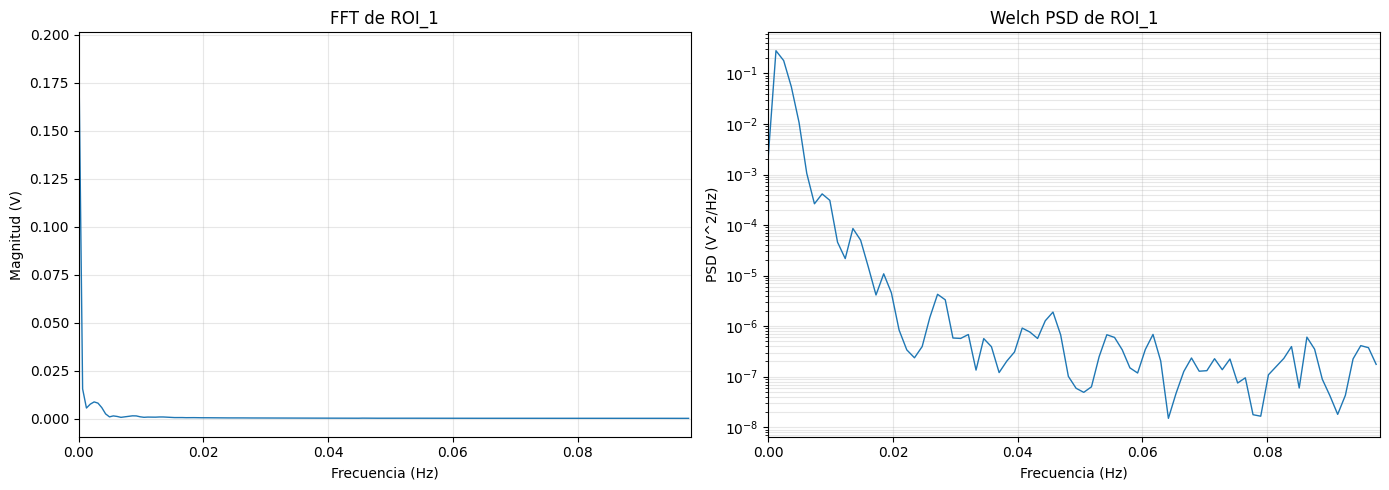

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# FFT
ax1.plot(freqs_fft, mag_fft, linewidth=1)
ax1.set_xlabel('Frecuencia (Hz)')
ax1.set_ylabel('Magnitud (V)')
ax1.set_title(f'FFT de {roi}')
ax1.set_xlim(0, min(0.5, fs/2))
ax1.grid(True, alpha=0.3)

# Welch
ax2.semilogy(freqs_welch, psd_welch, linewidth=1)
ax2.set_xlabel('Frecuencia (Hz)')
ax2.set_ylabel('PSD (V^2/Hz)')
ax2.set_title(f'Welch PSD de {roi}')
ax2.set_xlim(0, min(0.5, fs/2))
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

## 7. Guia de seleccion de parametros

### Savitzky-Golay

- **Ventana (sg_window):** debe ser impar y > orden polinomial. Tipicamente 10-30 muestras (equivalente a 10-30 segundos si fs ~ 1 Hz o menos).
  - Menor ventana -> menos suavizado, mas detalle
  - Mayor ventana -> mas suavizado, menos ruido (pero pierde picos abruptos)
- **Orden polinomial (sg_poly):** 2-4 típicamente. Mayor orden permite curvatura mas compleja pero riesgo de overfitting.

### Butterworth

- **Tipo (butter_type):** 
  - `lowpass`: elimina altas frecuencias (tipico para calcio)
  - `highpass`: elimina bajas frecuencias (baseline drift)
  - `bandpass`: elimina ambas (raro en calcio)
  - `bandstop`: elimina una banda (para ruido persistente)

- **Corte (butter_cutoff):** en Hz, debe estar en (0, Nyquist).
  - **Bajo (0.01-0.05 Hz)**: conserva eventos lentos, elimina oscilaciones rapidas
  - **Alto (0.1-0.3 Hz)**: mantiene mas detalle pero menos suavizado

- **Orden (butter_order):** 2-8 típicamente.
  - Orden bajo -> transicion suave, menos artefactos de fase
  - Orden alto -> transicion abrupta, mas amplificacion de fase

### Deteccion (rolling MAD)

- **Ventana de rolling (signal_window):** 10-50 muestras. Adapta el baseline a cambios lentos.
- **k_up, k_down:** umbrales en sigma robusta (MAD). Tipicamente 1.5-2.0.
  - k=1.65 detecta eventos 'moderados' (tolerancia media)
  - Menor k -> mas sensible pero mas falsos positivos
  - Mayor k -> menos sensible, solo eventos grandes

### Flujo recomendado

1. Cargar datos
2. Estimar fs
3. Ajustar sg_window segun duracion (10-20 muestras = 10-30 segundos tipicamente)
4. Observar espectro FFT/Welch para elegir butter_cutoff: eliminar ruido pero conservar eventos biologicos
5. Tuning de k_up/k_down viendo mascara de deteccion comparada contra senal visual
6. Calcular metricas por estimulo y revisar estadisticas (media, std, distribucion)

In [12]:
# Resumen de parametros y recomendaciones
print("=== RESUMEN DE PARAMETROS ===")
print(f"\nFrecuencia de muestreo: {fs:.2f} Hz")
print(f"Duracion total: {t[-1]:.1f} minutos")
print(f"Nyquist: {0.5*fs:.2f} Hz")

print(f"\n--- Savitzky-Golay ---")
print(f"Ventana: {sg_window} muestras = {sg_window/fs:.1f} segundos")
print(f"Orden: {sg_poly}")
print(f"Recomendado: ventana impar, entre {max(3, sg_window-10)} y {sg_window+10}")

print(f"\n--- Butterworth ---")
print(f"Tipo: {butter_type}")
print(f"Corte: {butter_cutoff} Hz")
print(f"Orden: {butter_order}")
print(f"Nyquist: {0.5*fs:.3f} Hz | Corte < Nyquist: {butter_cutoff < 0.5*fs}")
print(f"Recomendado: corte entre 0.01 y {min(0.2, 0.5*fs*0.8):.2f} Hz")

print(f"\n--- Deteccion ---")
print(f"Ventana rolling: {signal_window} muestras")
print(f"k_up: {k_up}, k_down: {k_down}")
print(f"Recomendado: k entre 1.0 (sensible) y 3.0 (conservador)")

print(f"\n=== INTERPRETACION ===")
print("- Mayor suavizado SG -> menos ruido, pero puede perder picos")
print("- Mayor corte Butterworth -> menos suavizado, mas detalle")
print("- Mayor k_up -> menos eventos detectados (umbral alto)")
print("- Menor k_up -> mas eventos, posibles falsos positivos") 

=== RESUMEN DE PARAMETROS ===

Frecuencia de muestreo: 0.20 Hz
Duracion total: 27.0 minutos
Nyquist: 0.10 Hz

--- Savitzky-Golay ---
Ventana: 15 muestras = 76.4 segundos
Orden: 3
Recomendado: ventana impar, entre 5 y 25

--- Butterworth ---
Tipo: lowpass
Corte: 0.05 Hz
Orden: 4
Nyquist: 0.098 Hz | Corte < Nyquist: True
Recomendado: corte entre 0.01 y 0.08 Hz

--- Deteccion ---
Ventana rolling: 20 muestras
k_up: 1.65, k_down: 1.65
Recomendado: k entre 1.0 (sensible) y 3.0 (conservador)

=== INTERPRETACION ===
- Mayor suavizado SG -> menos ruido, pero puede perder picos
- Mayor corte Butterworth -> menos suavizado, mas detalle
- Mayor k_up -> menos eventos detectados (umbral alto)
- Menor k_up -> mas eventos, posibles falsos positivos


## Conclusiones

Este notebook ha cubierto el flujo completo:
1. **Carga de datos** del formato de la app (txt con senales, csv con estimulos)
2. **Preprocesamiento** con SG (suavizado) y Butterworth (filtrado espectral)
3. **Deteccion robusta** usando rolling MAD e histéresis
4. **Metricas** por estimulo (area, duracion, maximo)
5. **Analisis espectral** con FFT y Welch
6. **Guia de parametros** para ajustar segun cada experimento

Cada parametro tiene un razonamiento fisico/estadistico. Ajustar basandose en:
- **Visual**: comparar filtrados, revisar detecciones visualmente
- **Estadistica**: numero de eventos, area promedio, duracion promedio
- **Conocimiento biologico**: frecuencias esperadas, magnitud de cambios fluorescentes